## Analysing effects of delivery ratio change on stock price 

In [3]:
#imports
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.feature_selection import mutual_info_classif
import shap
import matplotlib.pyplot as plt
import joblib

##### Load Data

In [4]:
#load data
df = pd.read_csv("processed_DRT_data.csv")
df['BH_TIMESTAMP'] = pd.to_datetime(df['BH_TIMESTAMP'])

#### Set Target

In [5]:
# Targets
# Calculate raw returns
df['future_3d_return'] = df['BH_CLOSE'].shift(-3) / df['BH_CLOSE'] - 1

# Stock-specific adaptive threshold (2% or 1.5x recent volatility)
df['volatility_threshold'] = df.groupby('BH_SYMBOL')['Returns_Daily'].transform(
    lambda x: x.rolling(20).std().fillna(0.02))
adaptive_threshold = np.maximum(0.02, 1.5 * df['volatility_threshold'])

# Create both binary and continuous targets
df['Price_Breakout_Binary'] = (df['future_3d_return'] > adaptive_threshold).astype(int)
df['Price_Breakout_Strength'] = df['future_3d_return'] / adaptive_threshold

# For probability modeling, use:
df['Price_Breakout_Prob'] = df.groupby('BH_SYMBOL')['Price_Breakout_Binary'].transform(
    lambda x: x.ewm(span=20, min_periods=10).mean())

#### Features

In [6]:
# Features
features = [col for col in df.columns if col not in [
    'BH_SYMBOL', 'BH_TIMESTAMP', 'Price_Breakout_Target', 'DRT_Increase_Target'] and df[col].dtype in [np.float64, np.int64]]

# Sort data by timestamp to ensure chronological order
df = df.sort_values('BH_TIMESTAMP')


#### Split Data

In [8]:

# Calculate split points
train_end = df['BH_TIMESTAMP'].quantile(0.8)
val_end = df['BH_TIMESTAMP'].quantile(0.9)

# Split into train (80%), validation (10%), and test (10%)
train = df[df['BH_TIMESTAMP'] < train_end]
val = df[(df['BH_TIMESTAMP'] >= train_end) & (df['BH_TIMESTAMP'] < val_end)]
test = df[df['BH_TIMESTAMP'] >= val_end]

print(f"Training set: {len(train)} samples ({train['BH_TIMESTAMP'].min()} to {train['BH_TIMESTAMP'].max()})")
print(f"Validation set: {len(val)} samples ({val['BH_TIMESTAMP'].min()} to {val['BH_TIMESTAMP'].max()})")
print(f"Test set: {len(test)} samples ({test['BH_TIMESTAMP'].min()} to {test['BH_TIMESTAMP'].max()})")

Training set: 145 samples (2024-09-02 00:00:00 to 2025-03-28 00:00:00)
Validation set: 18 samples (2025-04-01 00:00:00 to 2025-04-29 00:00:00)
Test set: 19 samples (2025-04-30 00:00:00 to 2025-05-27 00:00:00)


In [9]:
# Enhanced Target Variable Preparation --------------------------------

# 1. Calculate future returns and DRT changes
train['future_3d_return'] = train['BH_CLOSE'].shift(-3) / train['BH_CLOSE'] - 1
test['future_3d_return'] = test['BH_CLOSE'].shift(-3) / test['BH_CLOSE'] - 1

train['future_3d_drt_change'] = train['DRT'].shift(-3) - train['DRT']
test['future_3d_drt_change'] = test['DRT'].shift(-3) - test['DRT']

# 2. Calculate adaptive thresholds per stock
def get_adaptive_thresholds(df):
    # Price breakout threshold (max of 2% or 1.5x recent volatility)
    df['volatility_threshold'] = df.groupby('BH_SYMBOL')['Returns_Daily'].transform(
        lambda x: x.rolling(20).std().fillna(0.02))
    df['price_threshold'] = np.maximum(0.02, 1.5 * df['volatility_threshold'])
    
    # DRT change threshold (1.25x recent DRT volatility)
    df['drt_volatility'] = df.groupby('BH_SYMBOL')['DRT_Volatility_5'].transform(
        lambda x: x.rolling(10).mean().fillna(x.median()))
    df['drt_threshold'] = 1.25 * df['drt_volatility']
    return df

train = get_adaptive_thresholds(train)
test = get_adaptive_thresholds(test)

# 3. Create multiple target versions
def create_targets(df):
    # Price targets
    df['Price_Breakout_Binary'] = (df['future_3d_return'] > df['price_threshold']).astype(int)
    df['Price_Breakout_Strength'] = df['future_3d_return'] / df['price_threshold']
    df['Price_Breakout_Prob'] = df.groupby('BH_SYMBOL')['Price_Breakout_Binary'].transform(
        lambda x: x.ewm(span=20, min_periods=10).mean())
    
    # DRT targets
    df['DRT_Increase_Binary'] = (df['future_3d_drt_change'] > df['drt_threshold']).astype(int)
    df['DRT_Increase_Strength'] = df['future_3d_drt_change'] / df['drt_threshold']
    df['DRT_Increase_Prob'] = df.groupby('BH_SYMBOL')['DRT_Increase_Binary'].transform(
        lambda x: x.ewm(span=20, min_periods=10).mean())
    return df

train = create_targets(train)
test = create_targets(test)

# Final Target Selection --------------------------------------------

# For XGBoost models using probability targets with strength weights
X_train = train[features]
X_test = test[features]

# Price breakout targets
y_price_train = train['Price_Breakout_Prob']  # Probability target
price_sample_weights = train['Price_Breakout_Strength'].abs().clip(0.1, 3)  # Weight by strength

# DRT increase targets
y_drt_train = train['DRT_Increase_Prob']     # Probability target  
drt_sample_weights = train['DRT_Increase_Strength'].abs().clip(0.1, 3)

# For test set evaluation
y_price_test = test['Price_Breakout_Prob']
y_drt_test = test['DRT_Increase_Prob']



C:\Users\mehrs\AppData\Local\Temp\ipykernel_16448\3991254998.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['future_3d_return'] = train['BH_CLOSE'].shift(-3) / train['BH_CLOSE'] - 1
C:\Users\mehrs\AppData\Local\Temp\ipykernel_16448\3991254998.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['future_3d_return'] = test['BH_CLOSE'].shift(-3) / test['BH_CLOSE'] - 1
C:\Users\mehrs\AppData\Local\Temp\ipykernel_16448\3991254998.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [71]:
# 1. First, check for and handle NaN/infinite values in targets and weights
print("Checking for NaN/infinite values...")
for target in ['Price_Breakout_Prob', 'DRT_Increase_Prob',
              'Price_Breakout_Strength', 'DRT_Increase_Strength']:
    print(f"{target} - NaNs: {train[target].isna().sum()}, Infinite: {np.isinf(train[target]).sum()}")

Checking for NaN/infinite values...
Price_Breakout_Prob - NaNs: 9, Infinite: 0
DRT_Increase_Prob - NaNs: 9, Infinite: 0
Price_Breakout_Strength - NaNs: 3, Infinite: 0
DRT_Increase_Strength - NaNs: 3, Infinite: 0


#### Hyper Parameters

In [72]:
def clean_data(df):
    mask = (
        df['Price_Breakout_Prob'].notna() & 
        df['DRT_Increase_Prob'].notna() &
        ~np.isinf(df['Price_Breakout_Prob']) & 
        ~np.isinf(df['DRT_Increase_Prob']) &
        df['Price_Breakout_Strength'].notna() &
        df['DRT_Increase_Strength'].notna() &
        ~np.isinf(df['Price_Breakout_Strength']) &
        ~np.isinf(df['DRT_Increase_Strength'])
    )
    return df[mask].copy()

train_clean = clean_data(train)
test_clean = clean_data(test)

In [73]:
# For XGBoost models using probability targets with strength weights
# 3. Prepare cleaned data
X_train = train_clean[features]
X_test = test_clean[features]

# Price breakout targets
y_price_train = train_clean['Price_Breakout_Prob']  # Probability target
price_sample_weights = train_clean['Price_Breakout_Strength'].abs().clip(0.1, 3)  # Weight by strength

# DRT increase targets
y_drt_train = train_clean['DRT_Increase_Prob']     # Probability target  
drt_sample_weights = train_clean['DRT_Increase_Strength'].abs().clip(0.1, 3)

# For test set evaluation
y_price_test = train_clean['Price_Breakout_Prob']
y_drt_test = train_clean['DRT_Increase_Prob']

# 4. Verify no NaN/infinite values remain
assert not y_price_train.isna().any(), "NaNs in y_price_train"
assert not np.isinf(y_price_train).any(), "Infinite values in y_price_train"
assert not y_drt_train.isna().any(), "NaNs in y_drt_train"
assert not np.isinf(y_drt_train).any(), "Infinite values in y_drt_train"

# Classifier Params
params = {
    'objective': 'reg:logistic',  # For probability output
    'eval_metric': 'logloss',
    'eta': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 0.3,
    'lambda': 1,
    'min_child_weight': 10,
    'n_estimators': 1000,
    'early_stopping_rounds': 50,
    'tree_method': 'hist',
    'random_state': 42
}

params.pop('objective', None)  # Safely remove if present

'reg:logistic'

### Train Model

In [74]:
# 6. Train models
print("\nTraining Price Breakout Model...")
price_model = xgb.XGBRegressor(**params)
price_model.fit(
    X_train, 
    y_price_train, 
    sample_weight=price_sample_weights,
    eval_set=[(X_test, y_price_test)],
    verbose=50
)

print("\nTraining DRT Increase Model...")
drt_model = xgb.XGBRegressor(**params)
drt_model.fit(
    X_train, 
    y_drt_train,
    sample_weight=drt_sample_weights,
    eval_set=[(X_test, y_drt_test)],
    verbose=50
)


Training Price Breakout Model...


XGBoostError: [17:09:40] C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:54: Check failed: info.labels.Size() == preds.Size() (133 vs. 2527) : Invalid shape of labels.

#### Evaluation

In [8]:

# Evaluation
def evaluate(model, X, y_true, name):
    y_pred = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y_true, y_pred)
    print(f"{name} AUC: {auc:.4f}")
    print(classification_report(y_true, y_pred > 0.5))
    return y_pred

print("\nEvaluating Models...")
p_pred = evaluate(price_model, X_test, y_price_test, "Price Breakout")
d_pred = evaluate(drt_model, X_test, y_drt_test, "DRT Increase")



Evaluating Models...
Price Breakout AUC: 0.5719
              precision    recall  f1-score   support

           0       0.59      1.00      0.74     22146
           1       0.00      0.00      0.00     15703

    accuracy                           0.59     37849
   macro avg       0.29      0.50      0.37     37849
weighted avg       0.34      0.59      0.43     37849

DRT Increase AUC: 0.7851
              precision    recall  f1-score   support

           0       0.76      0.92      0.83     25950
           1       0.66      0.35      0.46     11899

    accuracy                           0.74     37849
   macro avg       0.71      0.64      0.64     37849
weighted avg       0.73      0.74      0.71     37849



#### SHAP

Running SHAP...


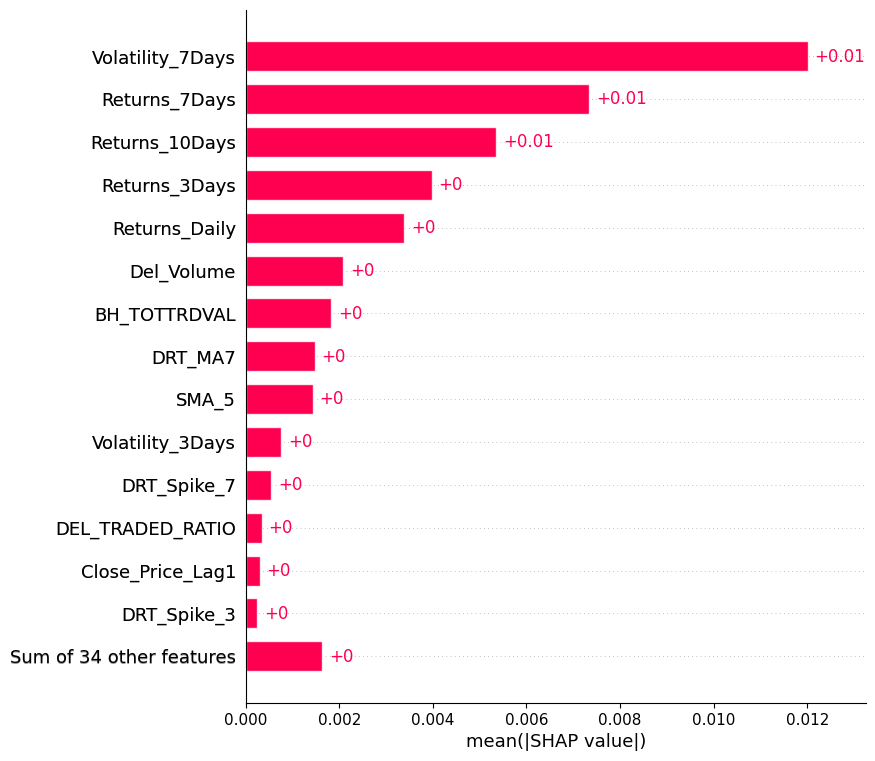

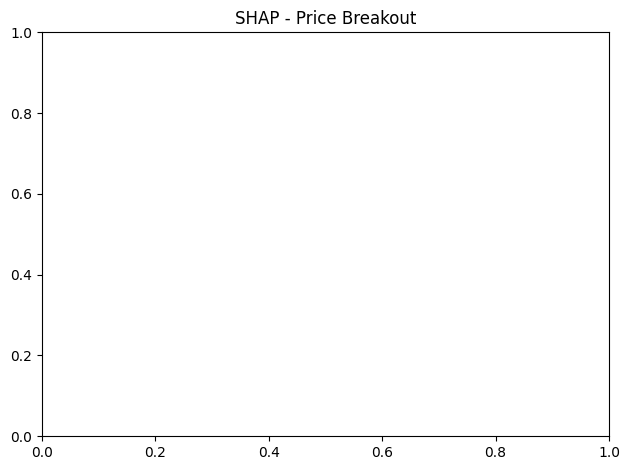

In [10]:
# SHAP
print("Running SHAP...")
explainer = shap.Explainer(price_model, X_train)
shap_values = explainer(X_test.sample(200))
shap.plots.bar(shap_values, max_display=15)
plt.title("SHAP - Price Breakout")
plt.tight_layout()
plt.show()


### List the stocks

In [ ]:
# Composite Score
print("Generating composite scores...")
results = test[['BH_SYMBOL', 'BH_TIMESTAMP', 'BH_CLOSE', 'DRT']].copy()
results['Price_Breakout_Prob'] = p_pred
results['DRT_Increase_Prob'] = d_pred
results['Composite_Score'] = 0.6 * p_pred + 0.4 * d_pred

top_stocks = results[(results['BH_CLOSE'] > 0) & (results['DRT'].between(0.1, 10))] \
    .sort_values('Composite_Score', ascending=False)

print("Top 10 Predictions:")
print(top_stocks.head(10))

Generating composite scores...
Top 10 Predictions:
        BH_SYMBOL BH_TIMESTAMP  BH_CLOSE   DRT  Price_Breakout_Prob  \
228785  NIF10GETF   2025-05-15     25.85  5.73             0.237984   
233524      NPBET   2025-05-08    278.49  7.40             0.238312   
221450    NARMADA   2025-05-23     16.75  6.11             0.246978   
117471   GREENLAM   2025-05-06    222.37  9.90             0.253032   
15124      ALICON   2025-05-22    901.50  8.95             0.253032   
298234      SIGMA   2025-05-02    285.35  6.31             0.249839   
9364     AEGISLOG   2025-05-08    798.45  8.79             0.245148   
36878   BAJAJELEC   2025-05-12    610.20  9.51             0.253032   
160968       JBMA   2025-05-05    692.35  6.92             0.253032   
162584  JINDWORLD   2025-05-08     64.12  7.84             0.254706   

        DRT_Increase_Prob  Composite_Score  
228785           0.919772         0.510699  
233524           0.904757         0.504890  
221450           0.881047       

<Figure size 1200x500 with 0 Axes>

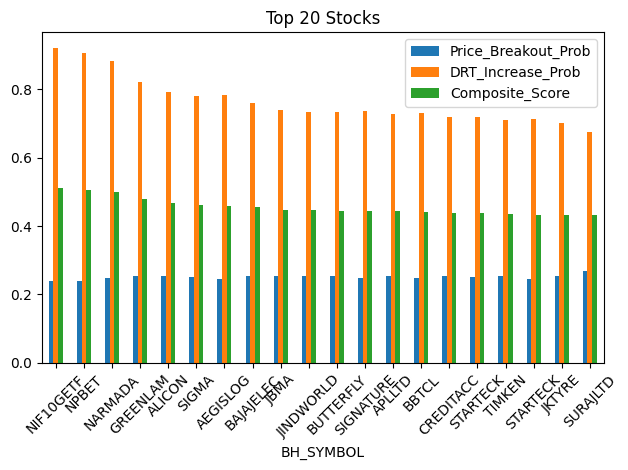

In [12]:
# Visualization
plt.figure(figsize=(12, 5))
top_stocks.head(20).plot(
    x='BH_SYMBOL', y=['Price_Breakout_Prob', 'DRT_Increase_Prob', 'Composite_Score'], kind='bar')
plt.title("Top 20 Stocks")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:

# Save
joblib.dump(price_model, 'price_breakout_model_clf.pkl')
joblib.dump(drt_model, 'drt_increase_model_clf.pkl')
joblib.dump(features, 'model_features_clf.pkl')
print("Artifacts saved.")
print("Features used for training:")
print(features)

Artifacts saved.
Features used for training:
['BH_OPEN', 'BH_HIGH', 'BH_LOW', 'BH_CLOSE', 'BH_LAST', 'BH_PREVCLOSE', 'BH_TOTTRDQTY', 'BH_TOTTRDVAL', 'BH_TOTALTRADES', 'DEL_QTY', 'TRADED_QTY', 'DEL_TRADED_RATIO', 'BH_TOKEN', 'Close_Price_Lag1', 'Close_Price_Lag3', 'Close_Price_Lag5', 'Close_Price_Lag7', 'Close_Price_Lag10', 'Price_Change_Daily', 'Price_Change_3Days', 'Price_Change_5Days', 'Price_Change_7Days', 'Price_Change_10Days', 'Returns_Daily', 'Returns_3Days', 'Returns_5Days', 'Returns_7Days', 'Returns_10Days', 'Volatility_3Days', 'Volatility_5Days', 'Volatility_7Days', 'SMA_3', 'SMA_5', 'SMA_7', 'DRT', 'DRT_Change_Daily', 'DRT_Change_3Days', 'DRT_Change_5Days', 'DRT_Change_7Days', 'DRT_Spike_3', 'DRT_Spike_5', 'DRT_Spike_7', 'Del_Volume', 'DRT_Volatility_3', 'DRT_Volatility_5', 'DRT_MA3', 'DRT_MA5', 'DRT_MA7']
